In [24]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from math import log
import numpy as np
!pip install pronouncing
import pronouncing

## HMM with customizable hidden states

In [25]:
#@title HMM Codes
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states

    def generate_seeded_emission(self, M, start_obs):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
            start_obs:  the seed word
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        states = []
        start_arr = np.array(self.O)
        prob = start_arr[:, 0]/np.sum(start_arr[:, 0])
        start_state = np.random.choice(self.L, p = prob)
        states.append(start_state)
        for i in range(M):
          state = states[i]
          obs = np.random.choice(self.D, p = np.array(self.O[state]))
          if i == 0:
            emission.append(start_obs)
          else:
            emission.append(obs)
          if i == M-1:
            return emission, states
          next_state = np.random.choice(self.L, p = np.array(self.A[state]))
          states.append(next_state)
        return emission, states

    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrices A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

## Auxiliary Modules:
Visualization, text-preprocessing and animation









In [33]:
#@title HMM Auxiliaries



def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)
    # For each state, get a list of observations that have been emitted
    # from that state.
  
    obs_count = []
    for i in range(n_states):   
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in np.unique(np.array(states)):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    # ignore all punctuations 
    # ignore arabic numerals 
    # hyphens and apostrophies are kept in place. Periods, commas, and other punctuations are ignored.

    # Requires that the a meaningful line can't be of length 1. This will exclude all title lines
    lines = [line.split() for line in text.split('\n') if (line.split() and len(line.split()) != 1)]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = word.lower()

            # the method replace('A', 'B') replaces string sequence A with string sequence B.
            word = word.replace(',', '')
            word = word.replace('.', '')
            word = word.replace(':', '')
            word = word.replace(';', '')
            word = word.replace('?', '')
            word = word.replace('!', '')
            word = word.replace('(', '')
            word = word.replace(')', '')

            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'

####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()

####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


## Visualization of the Shakespeare Corpus <br>






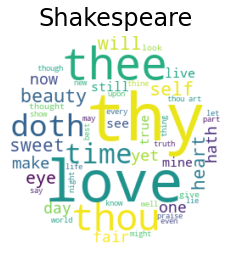

In [27]:
text = urllib.request.urlopen('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/shakespeare.txt').read().decode('utf-8')
wordcloud = text_to_wordcloud(text, title='Shakespeare')

# Poem Generation with Syllable Constraints

In [28]:
def text_to_dict(text):  
  # right now each word takes only one syllable
  lines = [line.split() for line in text.split('\r') if (line.split() and len(line.split()) != 1)]
  a_dictionary = {}
  for line in lines:
      if len(line) > 2:
        key = line[0]
        # make the end syllable count the second element in the values list
        if len(line[1]) == 2:
          value_end = line[1][1]  # get just the syllable count of the word at the end of a line
          value_reg = line[2]
        elif len(line[2]) == 2:
          value_end = line[2][1]  # get just the syllable count of the word at the end of a line
          value_reg = line[1]
        else:
          # account for syllable errors in the syllable dictionary text file          
            # words at the ends of lines sometimes have 1 less syllable counted than in other positions in the line
            if int(line[1]) < int(line[2]):
              value_end = line[1]  
              value_reg = line[2]         
            else:
              value_end = line[2]  
              value_reg = line[1]
        a_dictionary[key] = [value_reg, value_end]
      else:
        key, value = line
      a_dictionary[key] = [value]
  return a_dictionary

dict_text = urllib.request.urlopen('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt').read().decode('utf-8')
syll_dict = text_to_dict(dict_text)

In [29]:
def sample_sonnet(hmm, obs_map, syll_dict):
    # sonnets are 14 lines with 10 syllables a line
    obs_map_r = obs_map_reverser(obs_map)
    sonnet = ''
    for i in range(14):
      sonnet += sample_line(hmm, obs_map_r, syll_dict) + '\n'
      if i == 3 or i == 7 or i == 11:
        sonnet += '\n'
    return sonnet


def sample_line(hmm, obs_map_r, syll_dict):
    '''
        generate a sample line with exactly 10 syllables
    '''
    incomplete_line = True
    while incomplete_line:
      # sonnet lines are 10 syllables. We therefore need to generate a maximum of 10 words
      trial_emission, states = hmm.generate_emission(10)
      trial_sentence = [obs_map_r[i] for i in trial_emission]
      count = 0
      line = ''

      for i in range(len(trial_sentence)):
        word = trial_sentence[i]
        # initially set the syllable count of the word to the number in the middle of the line
        try:
          syll_count = int(syll_dict[word][0])
        except KeyError:
          word = word.replace("'", '')
          syll_count = int(syll_dict[word][0])
        # check if the word has different syllable counts for end of line and change if necessary
        if len(syll_dict[word]) > 1:
          if i == len(trial_sentence) - 1:
            # currently at the last word in the line
            syll_count = int(syll_dict[word][1])
          
        count += syll_count
        line += ' ' + word
        if count == 10:
          incomplete_line = False
          break
        if count > 10:
          # break from inner for loop and make another line
          break
    return line.capitalize()

## Train with varying numbers of hidden states <br>


In [23]:
obs, obs_map = parse_observations(text)
hmm1 = unsupervised_HMM(obs, 1, 100)
print('Sample Sonnet:\n====================')
random.seed(0)
print(sample_sonnet(hmm1, obs_map, syll_dict))

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Sample Sonnet:
 put due is of may summer bearing be
 born free for ground yet thee do verse sense from
 or point joy fitted her then rainy living
 posterity make on now white thou quick

 though and lawful shall me whoe'er being
 think hiding thy as willingly other
 drawn short against i the of the love see
 heaven favour with their sail that sway acquaintance

 false as or if mine least painted whose from
 now at antique tell of inward sweetest
 great i clean to sunk call with as thee my
 because o mayst for sweet on when my limbs

 some love's decayed my me his the it her
 his nymphs a to large they and be vowing



In [30]:
hmm4 = unsupervised_HMM(obs, 4, 100)
print('Sample Sonnet:\n====================')
print(sample_sonnet(hmm4, obs_map, syll_dict))

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Sample Sonnet:
 for to vainly of brass ignorance mark
 therefore in am him usest time the the
 honouring yore gave man's wooing victor
 behold transferred i that or i to for

 even that make lip lives thy flourish weakens
 impair to before which that gentlest thine
 i from have fade sell besiege my done as
 now alone no it low love increase dregs

 see you my sovereign now colour my youth
 the praise days thy changes doth might love's of
 and ever time mine with possesseth his
 to in good my o'er burden in in mad

 white other of to me am fits seeing not
 for of thy take seen have do was sweet me



In [31]:
hmm10 = unsupervised_HMM(obs, 10, 100)
print('Sample Sonnet:\n====================')
print(sample_sonnet(hmm10, obs_map, syll_dict))

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Sample Sonnet:
 forsworn there so is of me in lack can
 o sufficed truth against nor i forget
 vulgar acquaintance in but death's my dear
 linger joy and no praise to thoughts yet me

 to taken envy all and learned my him least
 of we lascivious feeble life till the
 sweet amiss might worthy him my moan not
 or for honour so is is by that you

 dulling which before deserve beauty by
 so remembered trespass sick me being
 acquainted have invention my appeal
 seldom self pity gave my soil time to

 if our deeds name inconstant visage
 right and distempered prophecies that them



## Visualization of the sparsities of A and O <br>

Visualize the sparsities of the A and O matrices by treating the matrix entries as intensity values and showing them as images. 

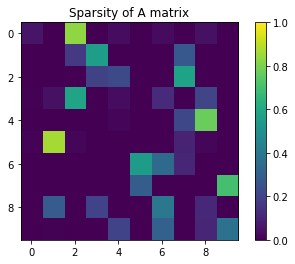

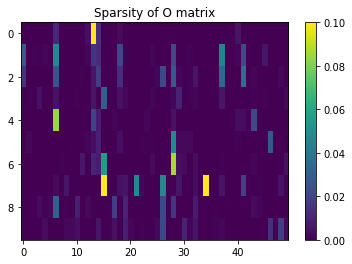

In [34]:
visualize_sparsities(hmm10, O_max_cols=50)

## Visualize the wordcloud of each HMM state 


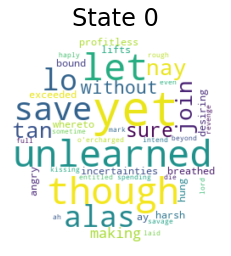

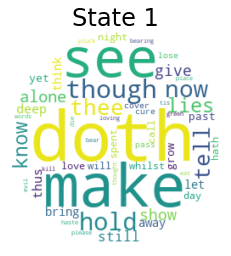

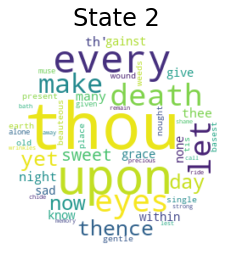

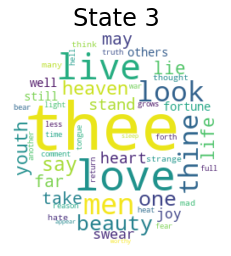

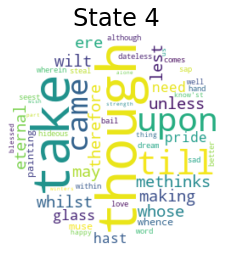

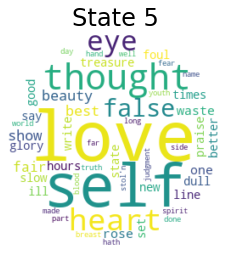

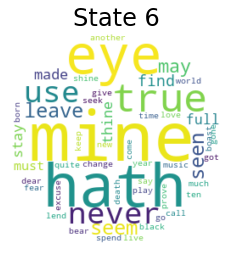

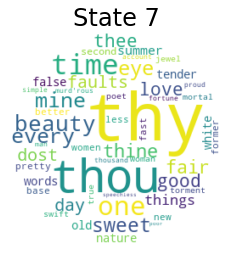

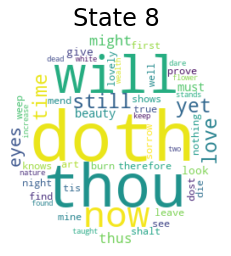

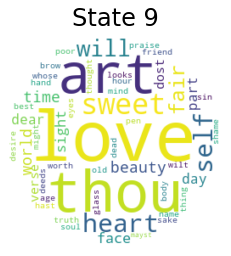

In [35]:
wordclouds = states_to_wordclouds(hmm10, obs_map)

## Animate the process of an HMM generating an emission <br>
The visualization below shows how an HMM generates an emission. Each state is shown as a wordcloud on the plot, and transition probabilities between the states are shown as arrows. The darker an arrow, the higher the transition probability.

At every frame, a transition is taken and an observation is emitted from the new state. A red arrow indicates that the transition was just taken. If a transition stays at the same state, it is represented as an arrowhead on top of that state.



Animating...


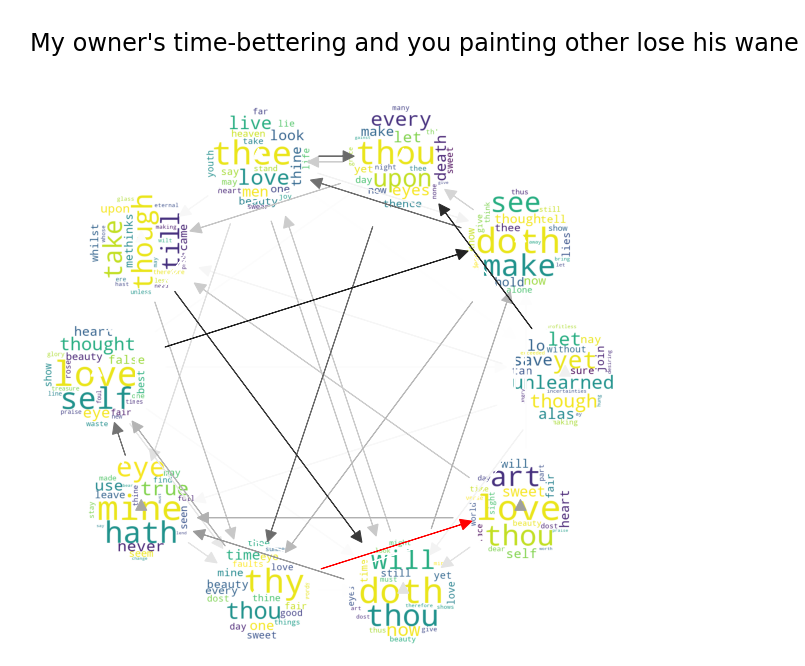

In [54]:
from IPython.display import HTML
anim = animate_emission(hmm10, obs_map, M=10)
HTML(anim.to_html5_video())

# Poem Generation with Iambic Pentameter Constraints
##Iamb: unstressed and stressed syllables alternating 
##Penta-: five feet (pairs) per line


In [37]:
def sample_sonnet_iambic(hmm, obs_map, syll_dict):

    # generate 14 lines (one sonnet) with 10 syllables in a line
    obs_map_r = obs_map_reverser(obs_map)
    sonnet = ''
    for i in range(14):
      sonnet += sample_line(hmm, obs_map_r, syll_dict) + '\n'
      if i == 3 or 7 or 11:
        sonnet += '\n'
    return sonnet


def sample_line_iambic(hmm, obs_map_r, syll_dict):
    line_incomplete = True
    while line_incomplete:
      # sonnet lines are 10 syllables
      emission, states = hmm.generate_emission(10)
      sentence = [obs_map_r[i] for i in emission]
      count = 0
      line = ''

      for i in range(len(sentence)):
        word = sentence[i]
        # initially set the syllable count of the word to the number in the middle of the line
        try:
          syll_count = int(syll_dict[word][0])
        except KeyError:
          word = word.replace("'", '')
          syll_count = int(syll_dict[word][0])
        # check if the word has different syllable counts for end of line and change if necessary
        if len(syll_dict[word]) > 1:
          if i == len(sentence) - 1:
            # this is the last word in the line
            syll_count = int(syll_dict[word][1])
          
        count += syll_count
        line += ' ' + word
        if count == 10:
            if is_iambic(line):
                # line is complete. return it
                line_incomplete = False
            break
        if count > 10:
          # break from inner for loop and make another line
          break
    return line.capitalize()


def is_iambic(text):
  isIambic = True
  DONT_CARE = 3
  # define 0 to be unstressed, 1 and 2 to be stressed, and 3 to a "don't care" state
  prev_word_meter = 1 # the first syllable should be unstressed
  words = text.split()
  for word in words:
    # must do try-except pairing because not all Shakespearean words are in the CMU dictionary of pronounciation 
    try:
      # curr meter is a string of the syllable stress sequence of the input word
      curr_meter = pronouncing.stresses(pronouncing.phones_for_word(word)[0])
      
      # check that syllables are stress-unstressed if not in don't care state
      if prev_word_meter != DONT_CARE:
        for syllable in curr_meter:
          # XOR previous syllable and current syllable
          if (bool(prev_word_meter) ^ bool(int(syllable))):
            prev_word_meter = int(syllable)

          else:
            isIambic = False
            break
      
      # if previous word was "don't care", get stress of last syllable of current word        
      else:
        prev_word_meter = int(curr_meter[-1])
    except:
      prev_word_meter = DONT_CARE
  
  return isIambic



In [38]:

print('Sample Sonnet:\n====================')
print(sample_sonnet_iambic(hmm10, obs_map, syll_dict))



Sample Sonnet:
 elements groan will beauty's no created none

 looks and will have effect that look on my

 see i while their living argument to

 bright the tongue may forgot night these accents

 and quality when you change distilled or

 i sun is spirit to my delight prove breast

 that newer might my not belong still if

 wasted in the for my added seem may

 and gav'st you hath strength that beauteous your truth

 shouldst thy should cloak heart overthrow an best

 his amiss when must welcome in than so

 the husbandry is store's that our thou

 are forbid may me seem consum'st enough

 my miles he yet so can bear better of




# Poem Generation with Pentameter (but not necessarily Iambic) and Rhyming Constraints

In [39]:
# Construct a ==Rhyming Dictionary from the original corpus

data = re.sub('\r\n\r\n\r\n ','',text)
words = re.findall(r'\S+|\n',data)


new_line_idx = [i for i, x in enumerate(words) if x == '\n']
title_idx = [i for i, x in enumerate(words) if x.isdigit() ]

rhyming_pairs = []
for start_of_poem in title_idx[0:-1]:
    first_new_line_idx = start_of_poem + 1
    idx_of_first_new_line_idx = new_line_idx.index(first_new_line_idx)
    pair1 = [words[new_line_idx[idx_of_first_new_line_idx + 1]-1], words[new_line_idx[idx_of_first_new_line_idx + 3]-1]]
    pair2 = [words[new_line_idx[idx_of_first_new_line_idx + 2]-1], words[new_line_idx[idx_of_first_new_line_idx + 4]-1]]
    pair3 = [words[new_line_idx[idx_of_first_new_line_idx + 5]-1], words[new_line_idx[idx_of_first_new_line_idx + 7]-1]]
    pair4 = [words[new_line_idx[idx_of_first_new_line_idx + 6]-1], words[new_line_idx[idx_of_first_new_line_idx + 8]-1]]
    pair5 = [words[new_line_idx[idx_of_first_new_line_idx + 9]-1], words[new_line_idx[idx_of_first_new_line_idx + 11]-1]]
    pair6 = [words[new_line_idx[idx_of_first_new_line_idx + 10]-1], words[new_line_idx[idx_of_first_new_line_idx + 12]-1]]
    pair7 = [words[new_line_idx[idx_of_first_new_line_idx + 13]-1], words[new_line_idx[idx_of_first_new_line_idx + 14]-2]]
    rhyming_pairs += [pair1,pair2,pair3,pair4,pair5,pair6,pair7]

# Get rid of the punctuation in the last line, if needed.
for i in range(len(rhyming_pairs)):
    for j in range(2):
        if not rhyming_pairs[i][j][-1].islower():
            rhyming_pairs[i][j] = rhyming_pairs[i][j][0:-1]



In [40]:
# Apply the same HMM but on the reversed data set

def reverse_observations(obs):
  #given a list of list of obs, reverse each inner
  for i in range(len(obs)):
    obs[i].reverse()
  return obs
  
hmm10r = unsupervised_HMM(reverse_observations(obs), 10, 100)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [41]:
def sample_rhyming_sonnet(hmm, obs_map, syll_dict, rhyming_pairs):
    # using a reverse trained hmm 
    # sonnets are 14 lines with 10 syllables a line
    obs_map_r = obs_map_reverser(obs_map)
    # sonnet has rhyming format: abab cdcd efef gg
    sonnet = ''
    lastwords = [None] * 14
    #pick out 7 rhyme pairs randomly from rhyming_pairs
    for i in range(7):
      r = random.randrange(len(rhyming_pairs))
      pair = rhyming_pairs[r]
      if i == 0 or i == 1:
        lastwords[i] = pair[0]
        lastwords[i + 2] = pair[1]
      elif i == 2 or i == 3:
        lastwords[i + 2] = pair[0]
        lastwords[i + 4] = pair[1]
      elif i == 4 or i == 5:
        lastwords[i + 4] = pair[0]
        lastwords[i + 6] = pair[1]
      else:
        lastwords[12] = pair[0]
        lastwords[13] = pair[1]

    for i in range(14):
      last_word = lastwords[i]
      sonnet += sample_backward_line(hmm, obs_map, obs_map_r, syll_dict,last_word) + '\n'
      if i == 3 or i == 7 or i == 11:
        sonnet += '\n'
    return sonnet


def sample_backward_line(hmm, obs_map, obs_map_r, syll_dict, last_word):
    # sonnet lines are 10 syllables
    start_obs = obs_map[last_word]
    emission, states = hmm.generate_seeded_emission(10, start_obs)
    sentence = [obs_map_r[i] for i in emission]
    count = 0
    line = []
    for word in sentence:
      count += int(syll_dict[word][0])
      line.append(word)
      if count == 10:
        break
      if count > 10:
        return sample_backward_line(hmm, obs_map, obs_map_r, syll_dict, last_word)
    line.reverse()
    return ' '.join(line).capitalize()

In [53]:
print('Sample Sonnet:\n====================')
random.seed(0)
print(sample_rhyming_sonnet(hmm10r, obs_map, syll_dict, rhyming_pairs))

Sample Sonnet:
Strains doom would young are motion deaths some sight
Truth shame age captive bear best thy name state
Again nor dare and life make grief's that night
Frown love to heaven thy eyes fair bright and hate

Blind ten and cross shadows and thou one go
Turns melancholy once scythe that learned the argument
Shows from this of wond'ring might express grow
Well-tuned doth this faces enough 'tis spent

Proud joy partake skill of thy winds never more
Successive gift heart not for one away
Sicken being my more on your abhor
Apparel gives the this are try sad stay

Own thee since self thou wilt it of each never
It back heat life thy upon flower fever

